In [ ]:
import pandas as pd
from scipy.spatial import distance
import numpy as np
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [ ]:
UK_covid_df = pd.read_csv("UK_covid.csv")
UK_covid_df['coord'] = UK_covid_df[['lat','lon']].apply(tuple, axis=1)
UK_covid_df = UK_covid_df.drop(columns= ['lat', 'lon'])
UK_covid_df

In [ ]:
UK_pol_df = pd.read_csv("UK_pol.csv")
UK_pol_df['coord'] = UK_pol_df[['lat','lon']].apply(tuple, axis=1)
UK_pol_df = UK_pol_df.drop(columns= ['lat', 'lon'])
UK_pol_df.head()

In [ ]:
n = UK_covid_df.shape[0]
m = UK_pol_df.shape[0]
UK_covid_df['sensor_site_name'] = np.zeros(n)
UK_covid_df['distance from the sensor [km]'] = np.zeros(n)
dist_vect = np.zeros(m)
#associating a station to each UK_covid_df
for idx1, row1 in UK_covid_df.iterrows():
    pos1= np.array(row1['coord'])
    for idx2, row2 in UK_pol_df.iterrows():
        pos2 = np.array(row2['coord']) #position of the sensor
        dst = distance.euclidean(pos1, pos2)
        dist_vect[idx2] = dst
    idx_min = np.where(dist_vect == np.amin(dist_vect))[0][0]
    UK_covid_df.loc[idx1, 'sensor_site_name'] = UK_pol_df.loc[idx_min,'site']
    p = row1['coord'] #sensor's position
    s = UK_pol_df.loc[idx_min, 'coord'] #associated sensor position
    UK_covid_df.loc[idx1, 'distance from the sensor [km]'] = geodesic(p, s).km

In [ ]:
threshold = 20
UK_covid_df = UK_covid_df[UK_covid_df['distance from the sensor [km]'] < threshold]
UK_covid_dff = UK_covid_df.groupby(['sensor_site_name'], as_index=False).agg({'# death':  np.sum})

In [42]:
#finally merge the two datasets
df_merged =  UK_covid_dff.merge(UK_pol_df, left_on='sensor_site_name', right_on='site')
df_merged.head()

,sensor_site_name,# death,site,no2,pm10,pm2.5,coord
0,Birmingham Tyburn,2355,Birmingham Tyburn,31.486575,18.136199,12.977897,"(52.51944, -1.8012700000000001)"
1,Bristol,450,Bristol,27.290171,17.094891,12.165736,"(51.45523, -2.59665)"
2,Bury,601,Bury,64.735355,23.568150,18.968763,"(53.6, -2.3)"
3,Cardiff Centre,800,Cardiff Centre,24.618499,17.752360,11.066149,"(51.450590000000005, -3.1867900000000002)"
4,Carlisle,109,Carlisle,25.497863,16.736710,10.123403,"(54.8951, -2.9382)"


In [41]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
df = df_merged.drop(columns = ['sensor_site_name', 'site', 'coord'])

# Standardizse the features
df_norm = (df-df.mean())/df.std()
df_norm.head()

,# death,no2,pm10,pm2.5
0,2.988487,0.283023,0.033119,0.218368
1,-0.310476,-0.003832,-0.278193,-0.103365
2,-0.048983,2.555826,1.657064,2.591620
3,0.295633,-0.186461,-0.081635,-0.538961
4,-0.900999,-0.126350,-0.385275,-0.912425


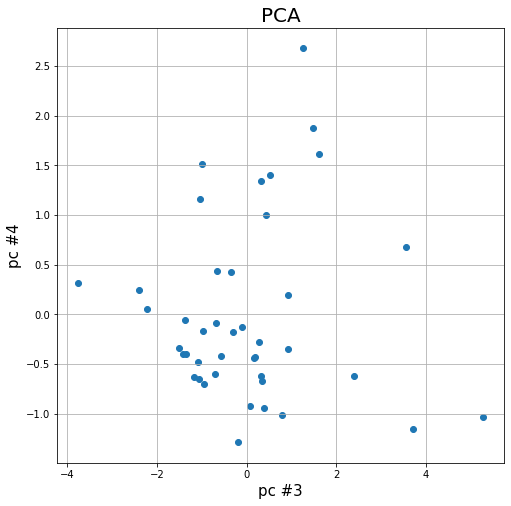

In [40]:
# Apply PCA
nc = 4
pca = decomposition.PCA(n_components=nc)
principalDf = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['pc #1', 'pc #2', 'pc #3', 'pc #4'])
principalDf

import matplotlib.pyplot as plt
df = principalDf
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 


ax.scatter(df.iloc[:,0], df.iloc[:,1])

ax.grid()
ax.set_xlabel(df.columns[2], fontsize = 15)
ax.set_ylabel(df.columns[3], fontsize = 15)
ax.set_title('PCA', fontsize = 20)
plt.show()

In [ ]:
nc = 4

# Apply PCA
pca = decomposition.PCA(n_components=nc)
PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['pc #1', 'pc #2', 'pc #3', 'pc #4'])
print("Singular values:", pca.singular_values_)
display(PCA_df)


# Append the target Label columns
target = pd.Series(np.hstack([np.zeros(N//2),np.ones(N//2)]) , name='label')

df = pd.concat([df, target], axis = 1)
PCA_df = pd.concat([PCA_df, target], axis = 1)
PCA_df.head()